# Quickstart: climate_indices on monthly precipitation and temperature

This notebook loads a small precipitation + temperature dataset bundled with the repo, computes
PET, SPI, SPEI, and percent-of-normal precipitation (PNP), and validates the results with plots.
Palmer/PDSI indices are intentionally omitted.


## Environment

Record versions for reproducibility. If running from the repo without installation, we add `src/`
so `import climate_indices` resolves to the local package.

To ensure all dependencies (including dask and matplotlib) are available, run Jupyter from the uv env:

- `uv sync --dev`
- `uv run jupyter lab` (or `uv run jupyter notebook`)

If you use a persistent kernel, install it from the uv env and select it in Jupyter.


In [1]:
import subprocess
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

try:
    import dask
except ModuleNotFoundError:
    dask = None
    print("dask is not installed; install it to run the Dask section: `python -m pip install dask`.")

try:
    import matplotlib
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    matplotlib = None
    print("matplotlib is not installed; install it to run plotting sections: `python -m pip install matplotlib`.")

HAS_DASK = dask is not None
HAS_MATPLOTLIB = matplotlib is not None

# Ensure local imports work when running from notebooks/ or repo root
cwd = Path.cwd().resolve()
if (cwd / "src" / "climate_indices").exists():
    repo_root = cwd
elif (cwd.parent / "src" / "climate_indices").exists():
    repo_root = cwd.parent
else:
    repo_root = cwd
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import climate_indices
from climate_indices import compute, indices


def _git_commit() -> str:
    try:
        return subprocess.check_output(["git", "rev-parse", "--short", "HEAD"], text=True).strip()
    except Exception:
        return "unknown"


dask_version = dask.__version__ if dask is not None else "not installed"
matplotlib_version = matplotlib.__version__ if matplotlib is not None else "not installed"

versions = {
    "climate_indices": climate_indices.__version__,
    "git_commit": _git_commit(),
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "xarray": xr.__version__,
    "dask": dask_version,
    "matplotlib": matplotlib_version,
}
versions

{'climate_indices': '2.2.0',
 'git_commit': '5640f5a',
 'numpy': '2.2.6',
 'pandas': '2.3.1',
 'xarray': '2025.6.1',
 'dask': '2025.7.0',
 'matplotlib': '3.10.5'}

## Data acquisition

We programmatically load a small precipitation + temperature dataset from the repo test fixtures
(`tests/fixture`). These fixtures are distributed under the repo's BSD-3-Clause license and keep
this demo fast. The data are used for validation purposes only and are not an observational product.


In [2]:
from pathlib import Path

fixture_dir = repo_root / "tests" / "fixture"
precip_path = fixture_dir / "precips_mm_monthly.npy"
temp_path = fixture_dir / "temp_celsius.npy"

precip_mm = np.load(precip_path)
temp_c = np.load(temp_path)

# Flatten to 1-D monthly series if fixtures are stored as (years, months)
precip_mm = np.asarray(precip_mm).reshape(-1)
temp_c = np.asarray(temp_c).reshape(-1)

assert precip_mm.size == temp_c.size

precip_mm.shape, temp_c.shape


((1476,), (1476,))

## Preprocessing best practices

- Time coordinate handling: build a monthly `time` axis that aligns with the data start year.
- Unit normalization: fixtures are already in `mm/month` and `degC`, so no conversion is needed.
- Missing data handling: keep NaNs as missing values to avoid biasing indices.


In [3]:
DATA_START_YEAR = 1895
CALIBRATION_START_YEAR = 1981
CALIBRATION_END_YEAR = 2010
LATITUDE_DEGREES = 25.2292

n_months = precip_mm.size
time = pd.date_range(f"{DATA_START_YEAR}-01-01", periods=n_months, freq="MS")

# Build xarray Dataset with clear variable names and units

ds = xr.Dataset(
    data_vars={
        "precip_mm": ("time", precip_mm, {"units": "mm/month", "long_name": "Monthly precipitation"}),
        "tmean_c": ("time", temp_c, {"units": "degC", "long_name": "Monthly mean temperature"}),
    },
    coords={"time": time},
    attrs={
        "source": "tests/fixture/*.npy in climate_indices",
        "license": "BSD-3-Clause (see LICENSE)",
    },
)

# Keep missing values as NaN
ds = ds.where(np.isfinite(ds))

ds

<xarray.Dataset> Size: 35kB
Dimensions:    (time: 1476)
Coordinates:
  * time       (time) datetime64[ns] 12kB 1895-01-01 1895-02-01 ... 2017-12-01
Data variables:
    precip_mm  (time) float64 12kB 37.31 85.7 28.04 129.4 ... nan nan nan nan
    tmean_c    (time) float64 12kB 19.65 15.66 21.11 22.28 ... nan nan nan nan
Attributes:
    source:   tests/fixture/*.npy in climate_indices
    license:  BSD-3-Clause (see LICENSE)

## Input data visualization

These plots confirm the expected seasonal structure and the overall range of the inputs.


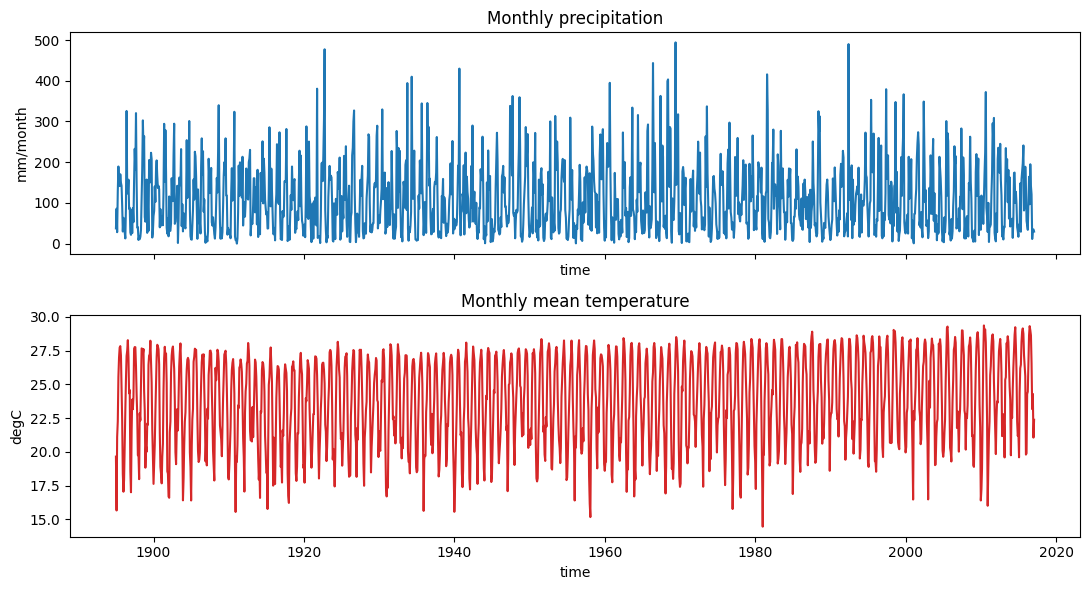

In [4]:
if not HAS_MATPLOTLIB:
    print("Skipping plots; install matplotlib to enable this section.")
else:
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    ds["precip_mm"].plot(ax=axes[0], color="tab:blue")
    axes[0].set_title("Monthly precipitation")
    axes[0].set_ylabel("mm/month")
    ds["tmean_c"].plot(ax=axes[1], color="tab:red")
    axes[1].set_title("Monthly mean temperature")
    axes[1].set_ylabel("degC")
    plt.tight_layout()


## Index demos (SPI, SPEI, PET, PNP)

We demonstrate both the direct numpy API and the xarray accessor for SPI.


In [5]:
precip_values = ds["precip_mm"].values
temp_values = ds["tmean_c"].values

# PET via Thornthwaite
pet_mm = indices.pet(
    temp_values,
    latitude_degrees=LATITUDE_DEGREES,
    data_start_year=DATA_START_YEAR,
)

# SPI-6 (gamma)
spi_6 = indices.spi(
    precip_values,
    scale=6,
    distribution=indices.Distribution.gamma,
    data_start_year=DATA_START_YEAR,
    calibration_year_initial=CALIBRATION_START_YEAR,
    calibration_year_final=CALIBRATION_END_YEAR,
    periodicity=compute.Periodicity.monthly,
)

# SPEI-6 (gamma) using P - PET
spei_6 = indices.spei(
    precip_values,
    pet_mm,
    scale=6,
    distribution=indices.Distribution.gamma,
    periodicity=compute.Periodicity.monthly,
    data_start_year=DATA_START_YEAR,
    calibration_year_initial=CALIBRATION_START_YEAR,
    calibration_year_final=CALIBRATION_END_YEAR,
)

# PNP-3 (ratio to normal)
pnp_3 = indices.percentage_of_normal(
    precip_values,
    scale=3,
    data_start_year=DATA_START_YEAR,
    calibration_start_year=CALIBRATION_START_YEAR,
    calibration_end_year=CALIBRATION_END_YEAR,
    periodicity=compute.Periodicity.monthly,
)

# Wrap outputs as DataArrays
pet_da = xr.DataArray(
    pet_mm,
    coords={"time": time},
    dims=("time",),
    name="pet_mm",
    attrs={"units": "mm/month", "long_name": "Potential evapotranspiration (Thornthwaite)"},
)

spi_6_da = xr.DataArray(
    spi_6,
    coords={"time": time},
    dims=("time",),
    name="spi_6",
    attrs={"units": "unitless", "long_name": "SPI-6 (gamma)"},
)

spei_6_da = xr.DataArray(
    spei_6,
    coords={"time": time},
    dims=("time",),
    name="spei_6",
    attrs={"units": "unitless", "long_name": "SPEI-6 (gamma)"},
)

pnp_3_da = xr.DataArray(
    pnp_3,
    coords={"time": time},
    dims=("time",),
    name="pnp_3",
    attrs={"units": "ratio", "long_name": "Percent of normal precipitation (3-month)"},
)

# Xarray accessor example (1-D only)
spi_6_xr = ds["precip_mm"].indices.spi(
    scale=6,
    distribution="gamma",
    data_start_year=DATA_START_YEAR,
    calibration_year_initial=CALIBRATION_START_YEAR,
    calibration_year_final=CALIBRATION_END_YEAR,
    periodicity=compute.Periodicity.monthly,
)

# Attach results to the dataset

ds = ds.assign(
    pet_mm=pet_da,
    spi_6=spi_6_da,
    spei_6=spei_6_da,
    pnp_3=pnp_3_da,
)

float(np.nanmax(np.abs(spi_6_xr.values - ds["spi_6"].values)))


0.0

## Output validation plots

SPI and SPEI should be centered near zero over the calibration period, with negative values
indicating drier-than-normal conditions. PNP values above 1 indicate wetter-than-normal conditions.


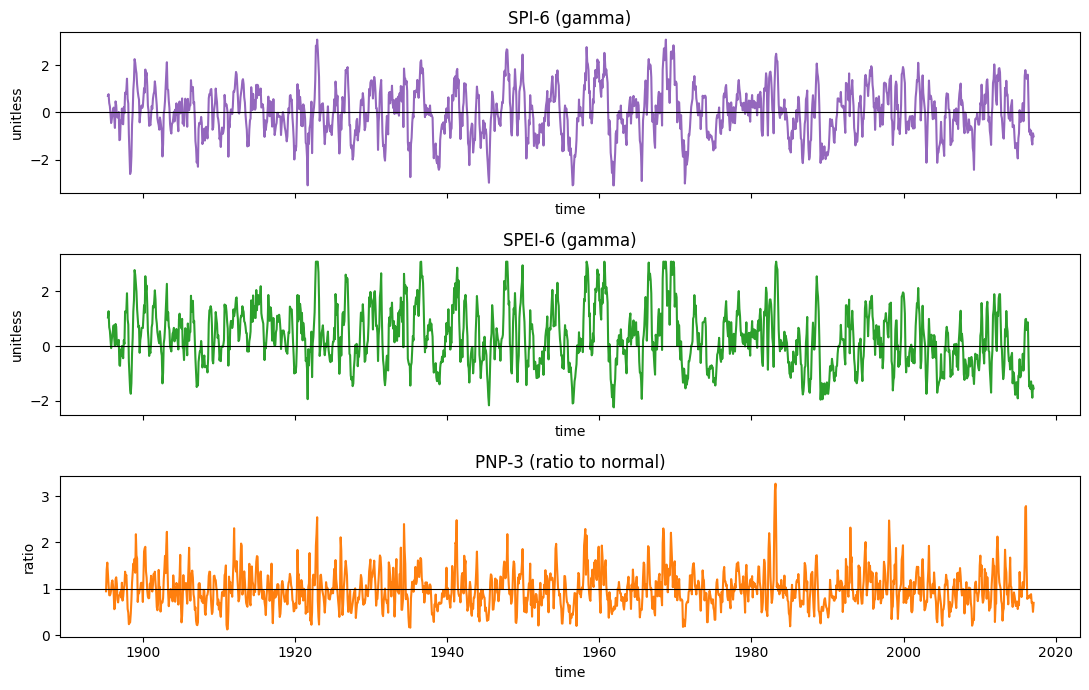

In [6]:
if not HAS_MATPLOTLIB:
    print("Skipping plots; install matplotlib to enable this section.")
else:
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(11, 7), sharex=True)
    
    
    ds["spi_6"].plot(ax=axes[0], color="tab:purple")
    axes[0].axhline(0.0, color="black", linewidth=0.8)
    axes[0].set_title("SPI-6 (gamma)")
    axes[0].set_ylabel("unitless")
    
    
    ds["spei_6"].plot(ax=axes[1], color="tab:green")
    axes[1].axhline(0.0, color="black", linewidth=0.8)
    axes[1].set_title("SPEI-6 (gamma)")
    axes[1].set_ylabel("unitless")
    
    
    ds["pnp_3"].plot(ax=axes[2], color="tab:orange")
    axes[2].axhline(1.0, color="black", linewidth=0.8)
    axes[2].set_title("PNP-3 (ratio to normal)")
    axes[2].set_ylabel("ratio")
    
    plt.tight_layout()


## Results and interpretation

- PET reflects the seasonal temperature cycle and provides the evaporative demand used by SPEI.
- SPI and SPEI fluctuate around zero and respond to wet and dry periods at the 6-month scale.
- PNP values near 1 indicate typical conditions, while values above or below 1 indicate wetter or
  drier conditions relative to the calibration period.


## Xarray + Dask workflow (small grid)

This section shows chunking best practices and xarray-native SPI computation using
`indices.spi_xarray`. The time dimension is kept as a single chunk so rolling windows do not cross
chunk boundaries.


In [7]:
if not HAS_DASK:
    print("Skipping Dask workflow; install dask to enable this section.")
    spi_grid = None
else:
    # Small spatial grid for a fast demo
    precip_series = ds["precip_mm"]

    lat = xr.DataArray([30.0, 31.5, 33.0], dims=("lat",), name="lat")
    lon = xr.DataArray([-100.0, -98.0, -96.0, -94.0], dims=("lon",), name="lon")

    # Base spatial scaling
    spatial_factor = xr.DataArray(
        [[0.9, 1.0, 1.1, 0.95], [1.05, 1.0, 0.98, 1.02], [1.1, 1.05, 0.97, 0.9]],
        dims=("lat", "lon"),
        coords={"lat": lat, "lon": lon},
    )

    # Add a deterministic, spatially varying seasonal perturbation so SPI fields are not uniform
    time_index = xr.DataArray(
        np.arange(precip_series.sizes["time"]),
        dims=("time",),
        coords={"time": precip_series["time"]},
    )
    spatial_phase = xr.DataArray(
        [[0.0, 0.5, 1.0, 1.5], [0.2, 0.7, 1.1, 1.6], [0.4, 0.9, 1.3, 1.8]],
        dims=("lat", "lon"),
        coords={"lat": lat, "lon": lon},
    )
    spatial_amp = xr.DataArray(
        [[0.03, 0.04, 0.05, 0.03], [0.02, 0.05, 0.04, 0.03], [0.04, 0.03, 0.02, 0.05]],
        dims=("lat", "lon"),
        coords={"lat": lat, "lon": lon},
    )
    seasonal = np.sin(2 * np.pi * time_index / 12 + spatial_phase)
    perturbation = 1 + spatial_amp * seasonal

    precip_grid = precip_series * spatial_factor * perturbation

    # Chunk for Dask: keep time as a single chunk for correct rolling behavior
    precip_grid_chunked = precip_grid.chunk({"time": -1, "lat": 1, "lon": 2})

    spi_grid = indices.spi_xarray(
        precip_grid_chunked,
        scale=6,
        distribution=indices.Distribution.gamma,
        data_start_year=DATA_START_YEAR,
        calibration_year_initial=CALIBRATION_START_YEAR,
        calibration_year_final=CALIBRATION_END_YEAR,
        periodicity=compute.Periodicity.monthly,
    )

    spi_grid


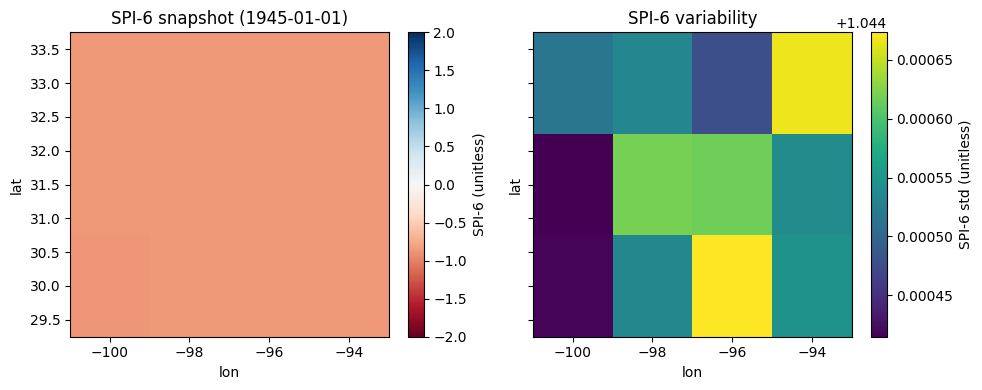

/Users/james.a/git/climate_indices/src/climate_indices/compute.py:854: RuntimeWarning: divide by zero encountered in divide
  alphas = (1 + np.sqrt(1 + 4 * a / 3)) / (4 * a)
/Users/james.a/git/climate_indices/.venv/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/james.a/git/climate_indices/src/climate_indices/compute.py:849: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
/Users/james.a/git/climate_indices/src/climate_indices/compute.py:852: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)
/Users/james.a/git/climate_indices/src/climate_indices/compute.py:851: RuntimeWarning: invalid value encountered in log
  logs = np.log(calibration_values)
/Users/james.a/git/climate_indices/src/climate_indices/eto.py:281: RuntimeWarning: invalid value encountered in divide
  * ((10.0 * monthly_temps_celsius[ye

In [8]:
if spi_grid is None:
    print("Skipping Dask plot; install dask to enable this section.")
elif not HAS_MATPLOTLIB:
    print("Skipping Dask plot; install matplotlib to enable plotting.")
else:
    import matplotlib.pyplot as plt

    # Plot a spatial snapshot and variability to show structure
    time_idx = 600
    if time_idx >= spi_grid.sizes["time"]:
        time_idx = spi_grid.sizes["time"] // 2

    spi_snapshot = spi_grid.isel(time=time_idx).compute()
    spi_std = spi_grid.std("time").compute()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True, sharey=True)

    spi_snapshot.plot(
        ax=axes[0],
        cmap="RdBu",
        vmin=-2,
        vmax=2,
        cbar_kwargs={"label": "SPI-6 (unitless)"},
    )
    axes[0].set_title(f"SPI-6 snapshot ({str(spi_snapshot['time'].values)[:10]})")

    spi_std.plot(
        ax=axes[1],
        cmap="viridis",
        cbar_kwargs={"label": "SPI-6 std (unitless)"},
    )
    axes[1].set_title("SPI-6 variability")

    plt.tight_layout()


## Compute and plot SPI and SPEI indices for example inputs
Below we define a function we can use to compute SPI and SPEI indices for example inputs we'll display below in subsequent cells.

In [9]:
from functools import partial

def compute_and_plot_indices(
    precip_path: Path,
    temp_path: Path,
    precip_var_name: str,
    temp_var_name: str,
    data_description: str,
    lat_chunk_size: int = 10,
    lon_chunk_size: int = 10,
) -> None:
    
    ds_prcp = xr.open_dataset(precip_path)
    ds_tavg = xr.open_dataset(temp_path)

    prcp_var = next((name for name in ds_prcp.data_vars if precip_var_name in name), list(ds_prcp.data_vars)[0])
    tavg_var = next((name for name in ds_tavg.data_vars if temp_var_name in name), list(ds_tavg.data_vars)[0])

    prcp = ds_prcp[prcp_var]
    tavg = ds_tavg[tavg_var]

    prcp, tavg = xr.align(prcp, tavg, join="inner")

    lat_name = "lat" if "lat" in prcp.coords else "latitude" if "latitude" in prcp.coords else prcp.dims[-2]
    lon_name = "lon" if "lon" in prcp.coords else "longitude" if "longitude" in prcp.coords else prcp.dims[-1]

    # Keep time as a single chunk for rolling operations
    if HAS_DASK:
        prcp = prcp.chunk({"time": -1, lat_name: lat_chunk_size, lon_name: lon_chunk_size})
        tavg = tavg.chunk({"time": -1, lat_name: lat_chunk_size, lon_name: lon_chunk_size})
        dask_mode = "parallelized"
    else:
        dask_mode = None

    data_start_year = int(prcp["time"].dt.year.min())
    calibration_year_initial = data_start_year
    calibration_year_final = int(prcp["time"].dt.year.max())

    spi = indices.spi_xarray(
        prcp,
        scale=6,
        distribution=indices.Distribution.gamma,
        data_start_year=data_start_year,
        calibration_year_initial=calibration_year_initial,
        calibration_year_final=calibration_year_final,
        periodicity=compute.Periodicity.monthly,
    )

    def _pet_safe(temps, lat):
        temps = np.array(temps, copy=True)
        return indices.pet(temps, lat, data_start_year=data_start_year)

    pet_func = _pet_safe
    pet = xr.apply_ufunc(
        pet_func,
        tavg,
        tavg[lat_name],
        input_core_dims=[["time"], []],
        output_core_dims=[["time"],],
        vectorize=True,
        dask=dask_mode,
        output_dtypes=[float],
        keep_attrs=True,
    )

    spei_func = partial(
        indices.spei,
        scale=6,
        distribution=indices.Distribution.gamma,
        periodicity=compute.Periodicity.monthly,
        data_start_year=data_start_year,
        calibration_year_initial=calibration_year_initial,
        calibration_year_final=calibration_year_final,
    )
    spei = xr.apply_ufunc(
        spei_func,
        prcp,
        pet,
        input_core_dims=[["time"], ["time"]],
        output_core_dims=[["time"],],
        vectorize=True,
        dask=dask_mode,
        output_dtypes=[float],
        keep_attrs=True,
    )

    time_idx = prcp.sizes["time"] // 2

    prcp_snapshot = prcp.isel(time=time_idx).transpose(lat_name, lon_name).compute()
    tavg_snapshot = tavg.isel(time=time_idx).transpose(lat_name, lon_name).compute()
    spi_snapshot = spi.isel(time=time_idx).transpose(lat_name, lon_name).compute()
    spei_snapshot = spei.isel(time=time_idx).transpose(lat_name, lon_name).compute()

    spi_vmin = float(spi_snapshot.quantile(0.02))
    spi_vmax = float(spi_snapshot.quantile(0.98))
    spei_vmin = float(spei_snapshot.quantile(0.02))
    spei_vmax = float(spei_snapshot.quantile(0.98))

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), sharex=True, sharey=True)

    prcp_snapshot.plot(
        ax=axes[0, 0],
        x=lon_name,
        y=lat_name,
        cmap="Blues",
        cbar_kwargs={"label": "Precipitation (mm/month)"},
    )
    axes[0, 0].set_title("Precipitation")

    tavg_snapshot.plot(
        ax=axes[0, 1],
        x=lon_name,
        y=lat_name,
        cmap="RdYlBu_r",
        cbar_kwargs={"label": "Temperature (degC)"},
    )
    axes[0, 1].set_title("Temperature")

    spi_snapshot.plot(
        ax=axes[1, 0],
        x=lon_name,
        y=lat_name,
        cmap="RdBu",
        vmin=spi_vmin,
        vmax=spi_vmax,
        cbar_kwargs={"label": "SPI-6 (unitless)"},
    )
    axes[1, 0].set_title("SPI-6")

    spei_snapshot.plot(
        ax=axes[1, 1],
        x=lon_name,
        y=lat_name,
        cmap="RdBu",
        vmin=spei_vmin,
        vmax=spei_vmax,
        cbar_kwargs={"label": "SPEI-6 (unitless)"},
    )
    axes[1, 1].set_title("SPEI-6")

    for ax in axes.ravel():
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    fig.suptitle(f"{data_description} snapshot ({str(prcp_snapshot['time'].values)[:10]})")
    plt.tight_layout()

## Example indices calculations

### NClimGrid from NOAA
Below we compute SPI and SPEI from the [NClimGrid](https://registry.opendata.aws/noaa-nclimgrid/) precipitation and temperature datasets from NOAA

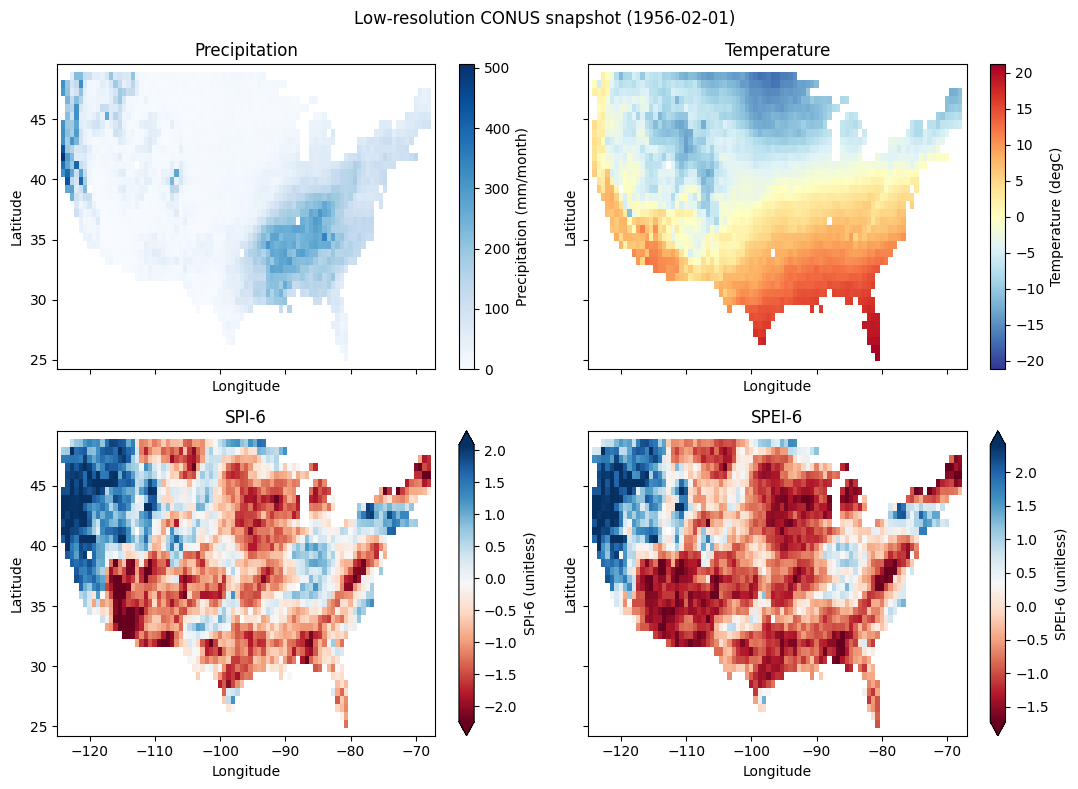

In [10]:
conus_precip_path = repo_root / "notebooks" / "data" / "nclimgrid_lowres_prcp.nc"
conus_temp_path = repo_root / "notebooks" / "data" / "nclimgrid_lowres_tavg.nc"

compute_and_plot_indices(
    precip_path=conus_precip_path,
    temp_path=conus_temp_path,
    precip_var_name="prcp",
    temp_var_name="tavg",
    data_description="Low-resolution CONUS"
)

### CRU TS from University of East Anglia
Below we compute SPI and SPEI from the CRU TS precipitation and temperature datasets from UEA
[Version 4.07](https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.07/Release_Notes_CRU_TS_4.07.txt)

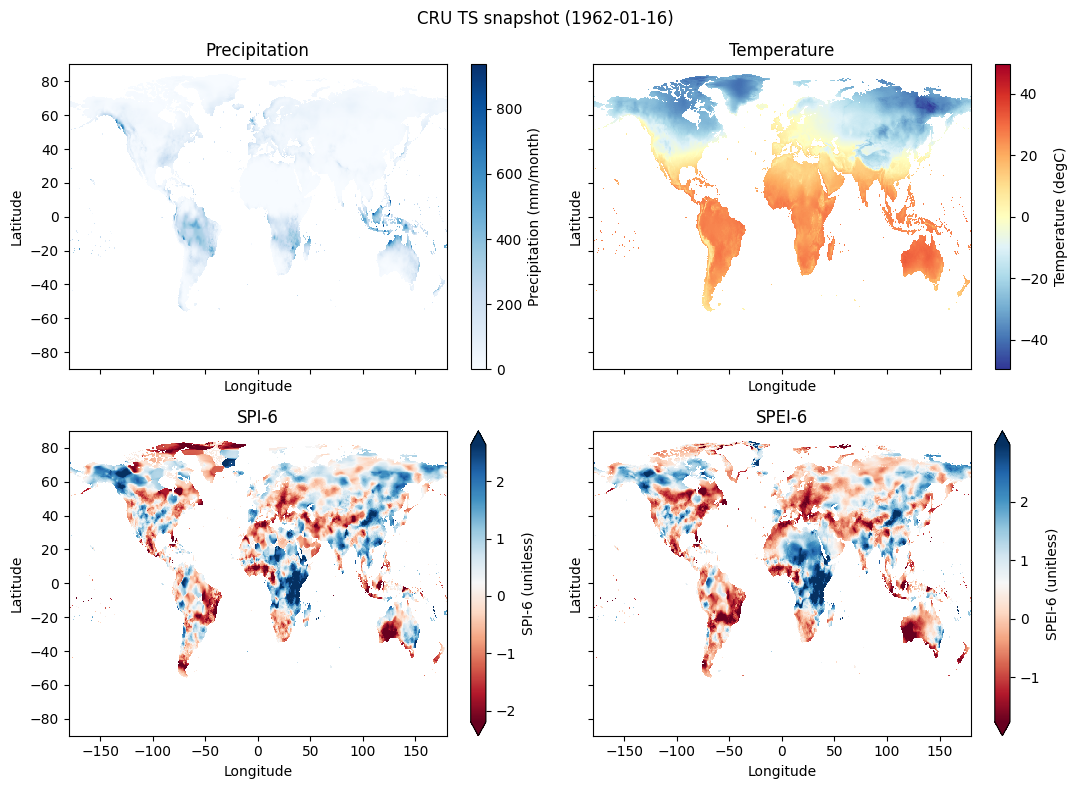

In [11]:
dask.config.set(scheduler="threads")

precip_path = repo_root / "notebooks" / "data" / "cru_ts4.07.1901.2022.pre.dat.nc"
temp_path = repo_root / "notebooks" / "data" / "cru_ts4.07.1901.2022.tmp.dat.nc"

compute_and_plot_indices(
    precip_path=precip_path,
    temp_path=temp_path,
    precip_var_name="pre",
    temp_var_name="tmp",
    data_description="CRU TS",
)

In [12]:
import dask
print("scheduler:", dask.config.get("scheduler"))

print("prcp backend:", type(prcp.data))
print("prcp chunks:", prcp.chunks)

print("tavg backend:", type(tavg.data))
print("tavg chunks:", tavg.chunks)

scheduler: threads


NameError: name 'prcp' is not defined